## Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import keras

import urllib
import json
from tqdm import tqdm
import cv2
from time import time
import os

#from pytube import YouTube, exceptions

from moviepy.editor import VideoFileClip
from collections import OrderedDict

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys

import h5py
import glob


import cv2
import random
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.7 MB/s eta 0:00:00
time: 410 µs (started: 2024-04-29 14:34:09 +00:00)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
time: 21.3 s (started: 2024-04-29 14:34:09 +00:00)


In [ ]:
# Only needed for data preprocessing!!
!pip install pytube

## Downloading and Preprocessing

In [ ]:
# adding a cache to theoretically hopefully speed things up
cache = {}  # url -> path

def download_video(url, filepath=None):
    '''
    Downloads the highest resolution video available from youtube
    Takes in the URL of the video and returns a Stream object
    '''
    if url in cache:
      return cache[url]
    else:
      # Create a YouTube object
      yt = YouTube(url)

      # Get the highest resolution stream
      stream = yt.streams.get_highest_resolution()

      # Download the video
      path = stream.download()

      # add downloaded vid to cache
      if len(cache) < 2000:
        cache[url] = path

      return path


In [ ]:
# adding a cache to speed things up
clip_cache = OrderedDict()

def preprocess_video(path, entry):
    '''
    Takes a local video and preprocess it by cropping the bounding box and cutting
    it down to the correct time
    '''
    width, height = int(entry['width']), int(entry['height'])

    if path in clip_cache:
      clip = clip_cache[path]
    else:
      # create VideoFileClip with target resolution given by the width and height
      # provided in the dataset
      clip = VideoFileClip(path, target_resolution=(height, width), verbose=False)

      # add to cache and limit cache due to RAM (could prob go higher on this)
      if len(clip_cache) > 500:
        clip_cache.popitem(last=True)
      clip_cache[path] = clip

    box = entry["box"]
    start_time, end_time = entry['start_time'], entry['end_time']

    # calculate the bounding box given the resolution we have
    y1 = int(box[0] * height)
    x1 = int(box[1] * width)
    y2 = int(box[2] * height)
    x2 = int(box[3] * width)

    shortened_clip = clip.subclip(start_time, end_time)
    return shortened_clip.crop(x1=x1, y1=y1, x2=x2, y2=y2)


In [ ]:

# metrics
videos_attempt = 0
videos_success = 0
videos_private = 0
videos_unavail = 0
videos_other = 0

partition = 'train'  # MUST be "train", "test", or "val"

# splice of dataset to process
splice_start = 16001
splice_end = 17000

# Open the JSON file for reading
with open(f'/content/drive/MyDrive/CSCI1470_Final_Project/MS-ASL/MSASL_{partition}.json', 'r') as file:
    # Parse the JSON file and convert it into a Python dictionary
    data = json.load(file)

    if splice_end > len(data):  # safeguard for end of dataset
      splice_end = len(data)
      print("Final Splice")  # lmk if this is the end of the dataset
    data = data[splice_start:splice_end]

    for entry in tqdm(data):
      videos_attempt += 1
      label = entry['text']
      url = entry['url']
      try:
        path = download_video(url)
        stream = preprocess_video(path, entry)

        # placing the preprocessed vid in the correct folder (test/train) and correct subfolder (class)
        newpath = f'/content/drive/MyDrive/CSCI1470_Final_Project/Preprocessed Data/{partition}/{label}'
        if not os.path.exists(newpath):
          os.makedirs(newpath)

        # save with filename as unique ms timestamp to prevent duplicate names overwriting other vids
        stream.write_videofile(newpath + '/' + str(int(time()*100)) + '.mp4', codec="libx264", logger=None)
        videos_success += 1

      except exceptions.VideoPrivate as e:  # youtube video is private
        videos_private += 1
      except exceptions.VideoUnavailable as e:  # youtube video no longer avail.
        videos_unavail += 1
      except urllib.error.HTTPError as e:  # youtube hates us
        print(e)
        break
      except Exception as e:  # other exceptions
        print(e)
        videos_other += 1

# print metrics
errors = videos_unavail + videos_private + videos_other
print(f"\nTotal attempted:       {videos_attempt}")
print(f"Successful downloads:  {videos_success}")
print(f"Private Vids:          {videos_private}")
print(f"Unavailable Vids:      {videos_unavail}")
print(f"Other Errors:          {videos_other}")


## Dataset Metrics

In [ ]:
from time import time
def create_dict_from_subdirs(directory_path):
  '''
  For use in creating dataset metrics
  '''
  # List all subdirectories using os.listdir
  subdirs = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]

  # Create a dictionary with subdirectory names as keys and number of files as values
  dir_dict = {subdir: len(os.listdir(os.path.join(directory_path, subdir))) for subdir in subdirs}

  return dir_dict

def count_classes_and_files(path):
  '''
  For use in creating dataset metrics
  '''
  count = 0
  classes = 0

  # Walk through the directory tree to count files and classes
  for root, dirs, files in os.walk(path):
      count += len(files)
      classes += len(dirs)

  # calculate how many classes there should be
  with open(f'/content/drive/MyDrive/CSCI1470_Final_Project/MS-ASL/MSASL_{part}.json', 'r') as file:
  # Parse the JSON file and convert it into a Python dictionary
    data = json.load(file)
  total = len(data)

  return count, classes, total

def plot_sample_frequencies(path):
  '''
  For use in creating dataset metrics
  '''
  dir_dict = create_dict_from_subdirs(path)

  quantity_to_freq = Counter(dir_dict.values())

  # Create lists for the plot
  quantities = list(quantity_to_freq.keys())
  frequencies = list(quantity_to_freq.values())

  # plot
  plt.bar(quantities, frequencies)
  plt.xlabel('Number of Samples')
  plt.ylabel('Classes')
  plt.xticks(np.arange(min(quantities), max(quantities)+1, 1), fontsize=7)
  plt.title('Histogram of Number of Samples vs Class')
  # plt.savefig(str(int(time())) + ".png")
  plt.show()

def calc_top_classes(path):
  '''
  For use in creating dataset metrics
  '''
  dir_dict = create_dict_from_subdirs(path)
  sorted_keys = sorted(dir_dict, key=dir_dict.get, reverse=True)
  return sorted_keys


time: 18.6 ms (started: 2024-04-29 15:00:34 +00:00)


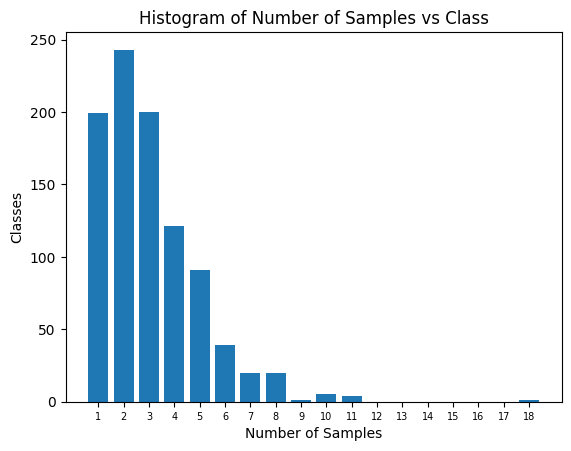

Partition:               test
Videos downloaded:       2879
Total videos in part:    4172
Percent yield:           0.6900767018216682
Classes:                 944 out of 1000

Top 100 Classes:           ['hello', 'sign', 'hi', 'need', 'paper', 'teacher', 'number', 'now', 'ready', 'sun', 'happy', 'dentist', 'doctor', 'spring', 'tired', 'walk', 'deaf', 'learn', 'sit', 'bake', 'right', 'football', 'ice-skating', 'school', 'busy', 'finish', 'pay', 'book', 'read', 'education', 'no', 'people', 'sell', 'mexico', 'mad', 'good', 'boat', 'buy', 'light', 'hard of hearing', 'teach', 'bed', 'summer', 'lost', 'homework', 'class', 'how are you', 'go', 'party', 'china', 'all', 'army', 'wrong', 'spain', 'hearing help', 'excited', 'how_many', 'brother', 'sister', 'want', 'closet', 'all night', 'cold', 'orange', 'beautiful', 'soccer', 'baseball', 'fine', 'write', 'yesterday', 'vomit', 'bored', 'like', 'frustrated', 'have', 'arrogant', 'big', 'pass', 'fast', 'cool', 'rude', 'quiet', 'weekend', 'slow', 'go

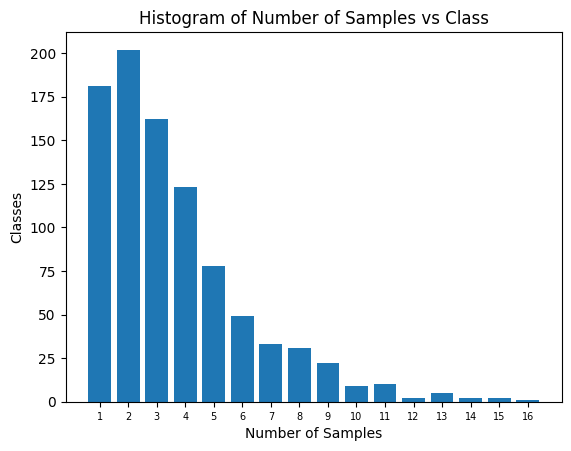

Partition:               val
Videos downloaded:       3287
Total videos in part:    5287
Percent yield:           0.6217136372233781
Classes:                 912 out of 1000

Top 100 Classes:           ['happy', 'not', 'sit', 'big', 'good', 'no', 'same', 'nice', 'yes', 'sorry', 'house', 'girl', 'phone', 'white', 'tired', 'like', 'first', 'forget', 'boy', 'father', 'ugly', 'you', 'bathroom', 'teacher', 'sad', 'how', 'man', 'but', 'eat', 'sell', 'bad', 'table', 'here', 'there', 'black', 'know', 'wrong', 'finish', 'fast', 'many', 'leave', 'student', 'school', 'baby', 'mother', 'what', 'beautiful', 'deaf', 'before', 'restaurant', 'can', 'again', 'buy', 'dinner', 'orange', 'teach', 'nervous', 'hungry', 'sick', 'coffee', 'tea', 'family', 'go', 'lost', 'remember', 'last', 'work', 'breakfast', 'nephew', 'sister', 'fish', 'hello', 'we', 'learn', 'right', 'thanks', 'bird', 'today', 'cheap', 'your', 'who', 'book', 'hot', 'refuse', 'not want', 'bicycle', 'doctor', 'nurse', 'not like', 'not know', 

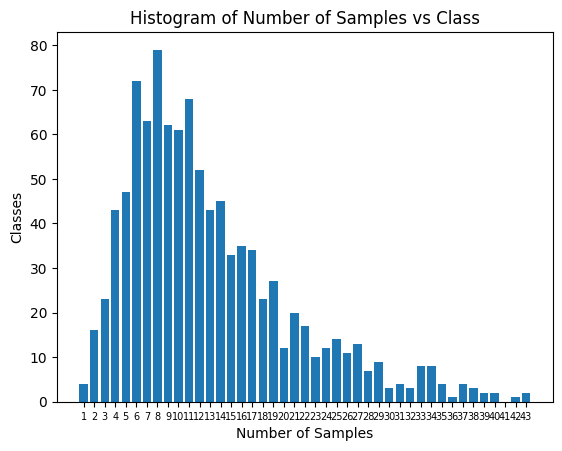

Partition:               train
Videos downloaded:       12873
Total videos in part:    16054
Percent yield:           0.8018562352061791
Classes:                 1000 out of 1000

Top 100 Classes:           ['eat', 'fish', 'bird', 'want', 'nice', 'mother', 'milk', 'sister', 'finish', 'friend', 'cousin', 'student', 'yes', 'water', 'teacher', 'father', 'drink', 'white', 'what', 'need', 'again', 'like', 'hungry', 'where', 'blue', 'orange', 'family', 'deaf', 'tired', 'brother', 'yellow', 'no', 'pencil', 'school', 'doctor', 'grandmother', 'grandfather', 'spring', 'help', 'english', 'night', 'table', 'you', 'black', 'man', 'sick', 'hurt', 'green', 'red', 'lost', 'when', 'please', 'girl', 'learn', 'book', 'how', 'cat', 'turkey', 'future', 'sunday', 'write', 'day', 'sad', 'hearing', 'brown', 'here', 'understand', 'apple', 'shoes', 'boy', 'sit', 'boyfriend', 'good', 'computer', 'bored', 'france', 'jacket', 'purple', 'dog', 'horse', 'time', 'cheese', 'cook', 'college', 'fine', 'happy', 'home', '

In [ ]:
# Dataset Metrics
#
# partitions = ['train']
partitions = ['test', 'val', 'train']

for part in partitions:
  path = f'/content/drive/MyDrive/CSCI1470_Final_Project/Preprocessed_Data/{part}'

  num_files, num_classes, exp_classes = count_classes_and_files(path)
  top_100_classes = calc_top_classes(path)[:100]
  plot_sample_frequencies(path)


  print(f"Partition:               {part}")
  print(f"Videos downloaded:       {num_files}")
  print(f"Total videos in part:    {exp_classes}")
  print(f"Percent yield:           {num_files/exp_classes}")
  print(f"Classes:                 {num_classes} out of 1000\n")
  print(f"Top 100 Classes:           {top_100_classes}")


In [ ]:

# train_top_100 = ['hello', 'sign', 'hi', 'need', 'paper', 'teacher', 'number', 'now', 'ready', 'sun', 'happy', 'dentist', 'doctor', 'spring', 'tired', 'walk', 'deaf', 'learn', 'sit', 'bake', 'right', 'football', 'ice-skating', 'school', 'busy', 'finish', 'pay', 'book', 'read', 'education', 'no', 'people', 'sell', 'mexico', 'mad', 'good', 'boat', 'buy', 'light', 'hard of hearing', 'teach', 'bed', 'summer', 'lost', 'homework', 'class', 'how are you', 'go', 'party', 'china', 'all', 'army', 'wrong', 'spain', 'hearing help', 'excited', 'how_many', 'brother', 'sister', 'want', 'closet', 'all night', 'cold', 'orange', 'beautiful', 'soccer', 'baseball', 'fine', 'write', 'yesterday', 'vomit', 'bored', 'like', 'frustrated', 'have', 'arrogant', 'big', 'pass', 'fast', 'cool', 'rude', 'quiet', 'weekend', 'slow', 'gone', 'late', 'explain', 'please', 'your', 'math', 'nurse', 'time', 'italy', 'day', 'watch', 'game', 'answer', 'so', 'bicycle', 'interpreter']
# val_top_100 = ['happy', 'not', 'sit', 'big', 'good', 'no', 'same', 'nice', 'yes', 'sorry', 'house', 'girl', 'phone', 'white', 'tired', 'like', 'first', 'forget', 'boy', 'father', 'ugly', 'you', 'bathroom', 'teacher', 'sad', 'how', 'man', 'but', 'eat', 'sell', 'bad', 'table', 'here', 'there', 'black', 'know', 'wrong', 'finish', 'fast', 'many', 'leave', 'student', 'school', 'baby', 'mother', 'what', 'beautiful', 'deaf', 'before', 'restaurant', 'can', 'again', 'buy', 'dinner', 'orange', 'teach', 'nervous', 'hungry', 'sick', 'coffee', 'tea', 'family', 'go', 'lost', 'remember', 'last', 'work', 'breakfast', 'nephew', 'sister', 'fish', 'hello', 'we', 'learn', 'right', 'thanks', 'bird', 'today', 'cheap', 'your', 'who', 'book', 'hot', 'refuse', 'not want', 'bicycle', 'doctor', 'nurse', 'not like', 'not know', 'computer', 'where', 'all', 'milk', 'woman', 'hill', 'hate', 'tall', 'niece', 'cold']
# test_top_100 = ['eat', 'fish', 'bird', 'want', 'nice', 'mother', 'milk', 'sister', 'finish', 'friend', 'cousin', 'student', 'yes', 'water', 'teacher', 'father', 'drink', 'white', 'what', 'need', 'again', 'like', 'hungry', 'where', 'blue', 'orange', 'family', 'deaf', 'tired', 'brother', 'yellow', 'no', 'pencil', 'school', 'doctor', 'grandmother', 'grandfather', 'spring', 'help', 'english', 'night', 'table', 'you', 'black', 'man', 'sick', 'hurt', 'green', 'red', 'lost', 'when', 'please', 'girl', 'learn', 'book', 'how', 'cat', 'turkey', 'future', 'sunday', 'write', 'day', 'sad', 'hearing', 'brown', 'here', 'understand', 'apple', 'shoes', 'boy', 'sit', 'boyfriend', 'good', 'computer', 'bored', 'france', 'jacket', 'purple', 'dog', 'horse', 'time', 'cheese', 'cook', 'college', 'fine', 'happy', 'home', 'aunt', 'uncle', 'shirt', 'bathroom', 'nothing', 'forget', 'wife', 'me', 'bus', 'name', 'slow', 'draw', 'play']

# train_ordered = calc_top_classes('/content/drive/MyDrive/CSCI1470_Final_Project/Preprocessed_Data/train')
# test_ordered = calc_top_classes('/content/drive/MyDrive/CSCI1470_Final_Project/Preprocessed_Data/test')
# val_ordered = calc_top_classes('/content/drive/MyDrive/CSCI1470_Final_Project/Preprocessed_Data/val')

top_100 = []
for i, c in enumerate(train_ordered):
  if c in test_ordered and c in val_ordered and len(top_100) < 100:
    top_100.append(c)


print(top_100)
print(len(top_100))


['eat', 'fish', 'bird', 'want', 'nice', 'mother', 'milk', 'sister', 'finish', 'friend', 'cousin', 'student', 'yes', 'water', 'teacher', 'father', 'drink', 'white', 'what', 'need', 'again', 'like', 'hungry', 'where', 'blue', 'orange', 'family', 'deaf', 'tired', 'brother', 'yellow', 'no', 'pencil', 'school', 'doctor', 'grandmother', 'grandfather', 'spring', 'help', 'english', 'night', 'table', 'you', 'black', 'man', 'sick', 'hurt', 'green', 'red', 'lost', 'when', 'please', 'girl', 'learn', 'book', 'how', 'cat', 'turkey', 'future', 'sunday', 'write', 'day', 'sad', 'hearing', 'brown', 'here', 'understand', 'apple', 'shoes', 'boy', 'sit', 'boyfriend', 'good', 'computer', 'bored', 'france', 'jacket', 'purple', 'dog', 'horse', 'time', 'cheese', 'cook', 'college', 'fine', 'happy', 'home', 'aunt', 'uncle', 'shirt', 'bathroom', 'nothing', 'forget', 'wife', 'me', 'bus', 'name', 'slow', 'draw', 'play', 'how_many', 'pink', 'walk', 'now', 'but', 'daughter', 'who', 'beautiful', 'nurse', 'movie', 'wom

In [ ]:
# Create a subset of the training data!
def create_subset(classes: list, source_root: str, dest_root: str):
  '''
  Creates a subset of the training data from a list of classes.
  '''
  parts = ['train', 'test', 'val']
  for part in parts:
    for dir in tqdm(classes):
      source = f'{source_root}/{part}/{dir}'
      destination = f'{dest_root}/{part}/{dir}'

      # Use shutil.copytree() to copy the folder
      try:
        shutil.copytree(source, destination)
      except FileNotFoundError as e:
        print(f'The class {dir} does not exist in {part}. Consider choosing a different class instead.')
      except FileExistsError as e:
        print(f'The folder {dir} already exists in {part}, so it was left unchanged.')


time: 9.93 ms (started: 2024-04-26 19:21:33 +00:00)


In [ ]:
train_top_five = ['eat', 'fish', 'bird', 'want', 'nice']
source = '/content/drive/MyDrive/CSCI1470_Final_Project/Preprocessed_Data'
dest = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes'

create_subset(top_100, source, dest)

100%|██████████| 100/100 [04:02<00:00,  2.42s/it]

time: 21min 37s (started: 2024-04-26 19:21:39 +00:00)


## Loading Data

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (176,176), frame_step = 1):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  if video_length >0:

    need_length = 1 + (n_frames - 1) * frame_step

    if need_length > video_length:
      start = 0
    else:
      max_start = video_length - need_length
      start = random.randint(0, max_start + 1)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    # ret is a boolean indicating whether read was successful, frame is the image itself
    ret, frame = src.read()
    result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
      for _ in range(frame_step):
        ret, frame = src.read()
      if ret:
        frame = format_frames(frame, output_size)
        result.append(frame)
      else:
        result.append(np.zeros_like(result[0]))
    src.release()
    result = np.array(result)[..., [2, 1, 0]]

    return result
  else:
    return False

time: 1.69 ms (started: 2024-04-29 08:30:51 +00:00)


In [ ]:
vid_path = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_Five_Classes/train/bird/171225909749.mp4'
sample_vid = frames_from_video_file(vid_path, 50)
vid_shape = sample_vid.shape


time: 2.04 s (started: 2024-04-29 08:30:53 +00:00)


In [ ]:
vid_shape

(50, 176, 176, 3)

time: 3.5 ms (started: 2024-04-29 08:30:56 +00:00)


## Create H5 File for Top 5

In [ ]:
############# DO NOT RUN ################################ (unless you tweaked the frame format function above or you want to recreate h5 files)

import random

types = ('*.mp4')
path = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_Five_Classes/train/'
num_classes = ['eat', 'fish', 'bird', 'want', 'nice']
num_classes_ind = [0,1,2,3,4]
files_grabbed = []
for target in num_classes:
  for files in types:
    files_grabbed.extend(glob.glob(path+target+'/'+files))

random.shuffle(files_grabbed)

f = h5py.File('/content/drive/MyDrive/CSCI1470_Final_Project/Top_Five_Classes/train/FiveClass_Dataset.h5', 'a')
print(f)

f.create_dataset('train_x', shape = (0, *vid_shape), maxshape=(None, *vid_shape))
f.create_dataset('train_y', shape = (0, len(num_classes)), maxshape=(None, len(num_classes)))
total_num_vid = len(files_grabbed)
counter = 0
for video in files_grabbed:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to train h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['train_y'].resize((f['train_y'].shape[0] + 1), axis=0)
            f['train_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['train_x'].resize((f['train_x'].shape[0] + 1), axis=0)
        f['train_x'][-1:] = sample_vid

f.close()

<HDF5 file "FiveClass_Dataset.h5" (mode r+)>
1 out of 213 videos processed to train h5 file
2 out of 213 videos processed to train h5 file
3 out of 213 videos processed to train h5 file
4 out of 213 videos processed to train h5 file
5 out of 213 videos processed to train h5 file
6 out of 213 videos processed to train h5 file


RuntimeError: Can't decrement id ref count (unable to extend file properly, errno = 107, error message = 'Transport endpoint is not connected')

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py/_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (unable to extend file properly, errno = 107, error message = 'Transport endpoint is not connected')


7 out of 213 videos processed to train h5 file
8 out of 213 videos processed to train h5 file
9 out of 213 videos processed to train h5 file
10 out of 213 videos processed to train h5 file
11 out of 213 videos processed to train h5 file
12 out of 213 videos processed to train h5 file
13 out of 213 videos processed to train h5 file
14 out of 213 videos processed to train h5 file
15 out of 213 videos processed to train h5 file
16 out of 213 videos processed to train h5 file
17 out of 213 videos processed to train h5 file
18 out of 213 videos processed to train h5 file
19 out of 213 videos processed to train h5 file
20 out of 213 videos processed to train h5 file
21 out of 213 videos processed to train h5 file
22 out of 213 videos processed to train h5 file
23 out of 213 videos processed to train h5 file
24 out of 213 videos processed to train h5 file
25 out of 213 videos processed to train h5 file
26 out of 213 videos processed to train h5 file
27 out of 213 videos processed to train h5 

In [ ]:
############# DO NOT RUN ################################ (unless you tweaked the frame format function above or you want to recreate h5 files)


import random
types = ('*.mp4')
path = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_Five_Classes/val/'
num_classes = ['eat', 'fish', 'bird', 'want', 'nice']
num_classes_ind = [0,1,2,3,4]
files_grabbed = []
for target in num_classes:
  for files in types:
    files_grabbed.extend(glob.glob(path+target+'/'+files))
random.shuffle(files_grabbed)

f = h5py.File('/content/drive/MyDrive/CSCI1470_Final_Project/Top_Five_Classes/val/FiveClass_Dataset.h5', 'a')
if 'val_x' in f:
  del f['val_x']
if 'val_y' in f:
  del f['val_y']
f.create_dataset('val_x', shape = (0, *vid_shape), maxshape=(None, *vid_shape))
f.create_dataset('val_y', shape = (0, len(num_classes)), maxshape=(None, len(num_classes)))
total_num_vid = len(files_grabbed)
counter = 0
for video in files_grabbed:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to val h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['val_y'].resize((f['val_y'].shape[0] + 1), axis=0)
            f['val_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['val_x'].resize((f['val_x'].shape[0] + 1), axis=0)
        f['val_x'][-1:] = sample_vid



1 out of 48 videos processed to val h5 file
2 out of 48 videos processed to val h5 file
3 out of 48 videos processed to val h5 file
4 out of 48 videos processed to val h5 file
5 out of 48 videos processed to val h5 file
6 out of 48 videos processed to val h5 file
7 out of 48 videos processed to val h5 file
8 out of 48 videos processed to val h5 file
9 out of 48 videos processed to val h5 file
10 out of 48 videos processed to val h5 file
11 out of 48 videos processed to val h5 file
12 out of 48 videos processed to val h5 file
13 out of 48 videos processed to val h5 file
14 out of 48 videos processed to val h5 file
15 out of 48 videos processed to val h5 file
16 out of 48 videos processed to val h5 file
17 out of 48 videos processed to val h5 file
18 out of 48 videos processed to val h5 file
19 out of 48 videos processed to val h5 file
20 out of 48 videos processed to val h5 file
21 out of 48 videos processed to val h5 file
22 out of 48 videos processed to val h5 file
23 out of 48 videos

In [ ]:
############# DO NOT RUN ################################ (unless you tweaked the frame format function above or you want to recreate h5 files)



types = ('*.mp4')
path = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_Five_Classes/test/'
num_classes = ['eat', 'fish', 'bird', 'want', 'nice']
num_classes_ind = [0,1,2,3,4]
files_grabbed = []
for target in num_classes:
  for files in types:
    files_grabbed.extend(glob.glob(path+target+'/'+files))
random.shuffle(files_grabbed)

f = h5py.File('/content/drive/MyDrive/CSCI1470_Final_Project/Top_Five_Classes/test/FiveClass_Dataset.h5', 'a')
if 'test_x' in f:
  del f['test_x']
if 'test_y' in f:
  del f['test_y']
f.create_dataset('test_x', shape = (0, *vid_shape), maxshape=(None, *vid_shape))
f.create_dataset('test_y', shape = (0, len(num_classes)), maxshape=(None, len(num_classes)))
total_num_vid = len(files_grabbed)
counter = 0
for video in files_grabbed:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to test h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['test_y'].resize((f['test_y'].shape[0] + 1), axis=0)
            f['test_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['test_x'].resize((f['test_x'].shape[0] + 1), axis=0)
        f['test_x'][-1:] = sample_vid



1 out of 28 videos processed to test h5 file
2 out of 28 videos processed to test h5 file
3 out of 28 videos processed to test h5 file
4 out of 28 videos processed to test h5 file
5 out of 28 videos processed to test h5 file
6 out of 28 videos processed to test h5 file
7 out of 28 videos processed to test h5 file
8 out of 28 videos processed to test h5 file
9 out of 28 videos processed to test h5 file
10 out of 28 videos processed to test h5 file
11 out of 28 videos processed to test h5 file
12 out of 28 videos processed to test h5 file
13 out of 28 videos processed to test h5 file
14 out of 28 videos processed to test h5 file
15 out of 28 videos processed to test h5 file
16 out of 28 videos processed to test h5 file
17 out of 28 videos processed to test h5 file
18 out of 28 videos processed to test h5 file
19 out of 28 videos processed to test h5 file
20 out of 28 videos processed to test h5 file
21 out of 28 videos processed to test h5 file
22 out of 28 videos processed to test h5 fi

## Create H5 Files for 100 Classes

In [ ]:
############# DO NOT RUN ################################ (unless you tweaked the frame format function above or you want to recreate h5 files)
vid_shape = [50,176,176,3]

types = ('*.mp4')
path = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/train/'
num_classes = os.listdir(path)
if 'HundredClass_Dataset.h5' in num_classes:
  print(True)
  num_classes.remove('HundredClass_Dataset.h5')

#num_classes = ['eat', 'fish', 'bird', 'want', 'nice']
num_classes_ind = np.arange(len(num_classes))
print('Total Number of classes: '+str(len(num_classes)))
files_grabbed = []
for target in num_classes:
  files_grabbed.extend(glob.glob(path+target+'/'+types))

random.shuffle(files_grabbed)


f = h5py.File('/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/train/HundredClass_Dataset.h5', 'a')
if 'train_x' in f:
  del f['train_x']
if 'train_y' in f:
  del f['train_y']
f.create_dataset('train_x', shape = (0, *vid_shape), maxshape=(None, *vid_shape))
f.create_dataset('train_y', shape = (0, len(num_classes)), maxshape=(None, len(num_classes)))
total_num_vid = len(files_grabbed)
counter = 0
for video in files_grabbed[:700]:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to train h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['train_y'].resize((f['train_y'].shape[0] + 1), axis=0)
            f['train_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['train_x'].resize((f['train_x'].shape[0] + 1), axis=0)
        f['train_x'][-1:] = sample_vid



Total Number of classes: 100
[ 135 1765 1407 ... 1062 1146 1106]


TypeError: only integer scalar arrays can be converted to a scalar index

time: 477 ms (started: 2024-04-29 08:37:43 +00:00)


In [ ]:
for video in files_grabbed[700:1400]:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to train h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['train_y'].resize((f['train_y'].shape[0] + 1), axis=0)
            f['train_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['train_x'].resize((f['train_x'].shape[0] + 1), axis=0)
        f['train_x'][-1:] = sample_vid

501 out of 3038 videos processed to train h5 file
502 out of 3038 videos processed to train h5 file
503 out of 3038 videos processed to train h5 file
504 out of 3038 videos processed to train h5 file
505 out of 3038 videos processed to train h5 file
506 out of 3038 videos processed to train h5 file
507 out of 3038 videos processed to train h5 file
508 out of 3038 videos processed to train h5 file
509 out of 3038 videos processed to train h5 file
510 out of 3038 videos processed to train h5 file
511 out of 3038 videos processed to train h5 file
512 out of 3038 videos processed to train h5 file
513 out of 3038 videos processed to train h5 file
514 out of 3038 videos processed to train h5 file
515 out of 3038 videos processed to train h5 file
516 out of 3038 videos processed to train h5 file
517 out of 3038 videos processed to train h5 file
518 out of 3038 videos processed to train h5 file
519 out of 3038 videos processed to train h5 file
520 out of 3038 videos processed to train h5 file


KeyboardInterrupt: 

time: 27min 21s (started: 2024-04-28 01:20:57 +00:00)


In [ ]:
for video in files_grabbed[1400:2100]:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to train h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['train_y'].resize((f['train_y'].shape[0] + 1), axis=0)
            f['train_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['train_x'].resize((f['train_x'].shape[0] + 1), axis=0)
        f['train_x'][-1:] = sample_vid

In [ ]:
for video in files_grabbed[2100:2800]:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to train h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['train_y'].resize((f['train_y'].shape[0] + 1), axis=0)
            f['train_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['train_x'].resize((f['train_x'].shape[0] + 1), axis=0)
        f['train_x'][-1:] = sample_vid

In [ ]:
for video in files_grabbed[2800:]:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to train h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['train_y'].resize((f['train_y'].shape[0] + 1), axis=0)
            f['train_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['train_x'].resize((f['train_x'].shape[0] + 1), axis=0)
        f['train_x'][-1:] = sample_vid

In [ ]:
############# DO NOT RUN ################################ (unless you tweaked the frame format function above or you want to recreate h5 files)



types = ('*.mp4')
path = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/'
num_classes = os.listdir(path)
if 'HundredClass_Dataset.h5' in num_classes:
  print(True)
  num_classes.remove('HundredClass_Dataset.h5')

#num_classes = ['eat', 'fish', 'bird', 'want', 'nice']
num_classes_ind = np.arange(len(num_classes))
print('Total Number of classes: '+str(len(num_classes)))
files_grabbed = []
for target in num_classes:
  files_grabbed.extend(glob.glob(path+target+'/'+types))

random.shuffle(files_grabbed)
print(files_grabbed)

f = h5py.File('/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/HundredClass_Dataset.h5', 'a')
if 'val_x' in f:
  del f['val_x']
if 'val_y' in f:
  del f['val_y']
f.create_dataset('val_x', shape = (0, *vid_shape), maxshape=(None, *vid_shape))
f.create_dataset('val_y', shape = (0, len(num_classes)), maxshape=(None, len(num_classes)))
total_num_vid = len(files_grabbed)
counter = 0
for video in files_grabbed:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to val h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['val_y'].resize((f['val_y'].shape[0] + 1), axis=0)
            f['val_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['val_x'].resize((f['val_x'].shape[0] + 1), axis=0)
        f['val_x'][-1:] = sample_vid



Total Number of classes: 100
['/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/future/1712023131.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/draw/1712082510.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/bathroom/1712081552.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/shirt/1712025321.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/day/1712101436.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/forget/1712098075.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/me/1712086178.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/how/1712022523.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/book/1712098958.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/black/1712085917.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/val/aunt/17

In [ ]:
############# DO NOT RUN ################################ (unless you tweaked the frame format function above or you want to recreate h5 files)

types = ('*.mp4')
path = '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/'
num_classes = os.listdir(path)
if 'HundredClass_Dataset.h5' in num_classes:
  print(True)
  num_classes.remove('HundredClass_Dataset.h5')

#num_classes = ['eat', 'fish', 'bird', 'want', 'nice']
num_classes_ind = np.arange(len(num_classes))
print('Total Number of classes: '+str(len(num_classes)))
files_grabbed = []
for target in num_classes:
  files_grabbed.extend(glob.glob(path+target+'/'+types))

random.shuffle(files_grabbed)
print(files_grabbed)

f = h5py.File('/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/HundredClass_Dataset.h5', 'a')
if 'test_x' in f:
  del f['test_x']
if 'test_y' in f:
  del f['test_y']
f.create_dataset('test_x', shape = (0, *vid_shape), maxshape=(None, *vid_shape))
f.create_dataset('test_y', shape = (0, len(num_classes)), maxshape=(None, len(num_classes)))
total_num_vid = len(files_grabbed)
counter = 0
for video in files_grabbed:
    counter += 1
    print(str(counter)+' out of ' + str(total_num_vid) + ' videos processed to test h5 file')
    if video[-3:] == 'mp4':
      sample_vid = frames_from_video_file(video, vid_shape[0])
      if type(sample_vid) != bool:
        for target in num_classes:
          if target in video:
            f['test_y'].resize((f['test_y'].shape[0] + 1), axis=0)
            f['test_y'][-1:] = tf.keras.utils.to_categorical([num_classes.index(target)], num_classes=len(num_classes))

        f['test_x'].resize((f['test_x'].shape[0] + 1), axis=0)
        f['test_x'][-1:] = sample_vid



Total Number of classes: 100
['/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/finish/1711941982.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/father/1712012009.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/yellow/1711941976.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/no/1711999611.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/me/1711938248.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/school/1711936903.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/want/1711932380.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/need/1711991526.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/brother/1711932270.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classes/test/school/1712011053.mp4', '/content/drive/MyDrive/CSCI1470_Final_Project/Top_100_Classe